In [38]:
## Description: What are the causal factors behind hotel booking cancellations?
# There are many reasons for a booking to be cancelled: a customer may request something that is unavailabile, a customer finds that the hotel does not satisfy their requirements, etc.

## Source: DoWhy docs in https://www.pywhy.org/dowhy/v0.8/example_notebooks/DoWhy-The%20Causal%20Story%20Behind%20Hotel%20Booking%20Cancellations.html
## Data Source: https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md


In [70]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from patsy import dmatrix
from joblib import Parallel, delayed # for parallel processing
from toolz import partial
from dowhy import CausalModel
import pygraphviz

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [40]:
# Response variable is the total spend at the end of the year (rewards program started Jan 2019)
# Creating some simulated data for our example

dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [41]:
dataset.shape

In [42]:
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

### Feature Engineering

Dimension reduction, data imputation, new feature creation

In [43]:
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights'] + dataset['stays_in_weekend_nights']

# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] + dataset['babies']

# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices = dataset['reserved_room_type'] != dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned'] = 1

# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)

dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')

In [44]:
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries
dataset = dataset.drop(['agent','company'],axis=1)

# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

In [45]:
dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
dataset = dataset.drop(['arrival_date_year'],axis=1)
dataset = dataset.drop(['distribution_channel'], axis=1) # high overlap with market_segment

In [46]:
# Replacing 1 by True and 0 by False for the experiment and outcome variables
dataset['different_room_assigned'] = dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned'] = dataset['different_room_assigned'].replace(0,False)

dataset['is_canceled'] = dataset['is_canceled'].replace(1,True)
dataset['is_canceled'] = dataset['is_canceled'].replace(0,False)

dataset.dropna(inplace=True)
print(dataset.columns)

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')


In [47]:
dataset.iloc[:, 5:20].head(100)

,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests
0,BB,PRT,Direct,0,0,0,3,No Deposit,0,Transient,0.00,0,0,0,2.0
1,BB,PRT,Direct,0,0,0,4,No Deposit,0,Transient,0.00,0,0,0,2.0
2,BB,GBR,Direct,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
3,BB,GBR,Corporate,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
4,BB,GBR,Online TA,0,0,0,0,No Deposit,0,Transient,98.00,0,1,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,73.80,0,1,2,2.0
96,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,117.00,0,1,7,2.0
97,HB,ESP,Offline TA/TO,0,0,0,0,No Deposit,0,Transient,196.54,0,1,7,3.0
98,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,99.30,1,2,7,3.0


In [48]:
dataset = dataset[dataset.deposit_type=="No Deposit"]
dataset.groupby(['deposit_type','is_canceled']).count()

hotel  lead_time  arrival_date_month  \
deposit_type is_canceled                                         
No Deposit   False        74947      74947               74947   
             True         29690      29690               29690   

                          arrival_date_week_number   meal  country  \
deposit_type is_canceled                                             
No Deposit   False                           74947  74947    74947   
             True                            29690  29690    29690   

                          market_segment  is_repeated_guest  \
deposit_type is_canceled                                      
No Deposit   False                 74947              74947   
             True                  29690              29690   

                          previous_cancellations  \
deposit_type is_canceled                           
No Deposit   False                         74947   
             True                          29690   

                          previous_bookings_not_canceled  booking_changes  \
deposit_type is_canceled                                                    
No Deposit   False                                 74947            74947   
             True                                  29690            29690   

                          days_in_waiting_list  customer_type    adr  \
deposit_type is_canceled                                               
No Deposit   False                       74947          74947  74947   
             True                        29690          29690  29690   

                          required_car_parking_spaces  \
deposit_type is_canceled                                
No Deposit   False                              74947   
             True                               29690   

                          total_of_special_requests  total_stay  guests  \
deposit_type is_canceled                                                  
No Deposit   False                            74947       74947   74947   
             True                             29690       29690   29690   

                          different_room_assigned  
deposit_type is_canceled                           
No Deposit   False                          74947  
             True                           29690

In [49]:
dataset_copy = dataset.copy(deep=True)

### Exploratory Data Analysis

In [50]:
# Run a simulation 10,000 times on a sample of 1,000
# There is near 50% chance of is_canceled and different_room_assigned being both true or false
# Assigning rooms different to what a customer had reserved during his booking earlier, may or may not lead to him cancelling that booking
counts_sum = 0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset.sample(1000)
        counts_i = rdf[rdf["is_canceled"] == rdf["different_room_assigned"]].shape[0]
        counts_sum += counts_i
        
counts_sum/10000

In [51]:
# Expected Count when there are no booking changes
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"] == 0].sample(1000)
        counts_i = rdf[rdf["is_canceled"] == rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i

counts_sum/10000

In [52]:
# Expected Count when there are booking changes (> 0) = 66.4%
# Indicates that booking changes may effect room cancellations when different rooms was assigned (when is_canceled = different_room_assigned)
# was not cancelled with no reassignment of rooms or was cancelled with reassignment of rooms
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"] > 0].sample(1000)
        counts_i = rdf[rdf["is_canceled"] == rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i

counts_sum/10000

### DoWhy: Graphical Causal Model Model based Inference

Represent prior knowledge about the modeling problem with a DAG:

Market Segment has 2 levels, “TA” refers to the “Travel Agents” and “TO” means “Tour Operators” so it should affect the Lead Time (which is simply the number of days between booking and arrival).

Country would also play a role in deciding whether a person books early or not (hence more Lead Time) and what type of Meal a person would prefer.

Lead Time would definitely affect the number of Days in Waitlist (There are lesser chances of finding a reservation if you’re booking late). Additionally, higher Lead Times can also lead to Cancellations.

The number of Days in Waitlist, the Total Stay in nights and the number of Guests might affect whether the booking is cancelled or retained.

Previous Booking Retentions would affect whether a customer is a repeat guest or not. Additionally, both of these variables would affect whether the booking get cancelled or not (Ex- A customer who has retained his past 5 bookings in the past has a higher chance of retaining this one also. Similarly a person who has been cancelling this booking has a higher chance of repeating the same).

Booking Changes would affect whether the customer is assigned a different room or not which might also lead to cancellation.


In [53]:
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders",observed="no"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U->{different_room_assigned,required_car_parking_spaces,guests,total_stay,total_of_special_requests};
market_segment -> lead_time;
lead_time->is_canceled; 
country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->{is_canceled,different_room_assigned};
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> {different_room_assigned,is_canceled};
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; 
booking_changes -> is_canceled;
hotel -> {different_room_assigned,is_canceled};
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> {booking_changes,is_canceled};
country->{hotel, required_car_parking_spaces,total_of_special_requests};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests};
}"""

c:\Users\arsep\anaconda3\envs\ds1\Lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


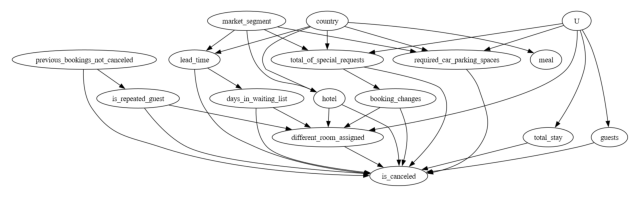

In [54]:
# Treatment = Assigning the same room reserved by the customer during the booking
# Outcome/Response = Booking was cancelled or not
model = CausalModel(
        data = dataset,
        graph = causal_graph.replace("\n", " "),
        treatment = "different_room_assigned",
        outcome = 'is_canceled')

model.view_model()

In [55]:
# Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[is_canceled|guests,is_repeated_guest,days_in_wait
d[different_room_assigned]                                                    

                                                                              
ing_list,lead_time,booking_changes,total_stay,total_of_special_requests,hotel,
                                                                              

                             
required_car_parking_spaces])
                             
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,guests,is_repeated_guest,days_in_waiting_list,lead_time,booking_changes,total_stay,total_of_special_requests,hotel,required_car_parking_spaces,U) = P(is_canceled|different_room_assigned,guests

ATE = Average Treatment Effect </br>
ATT = Average Treatment Effect on Treated (i.e., those who were assigned a different room) </br>
ATC = Average Treatment Effect on Control (i.e., those who were not assigned a different room) </br>

#### Distance Matching

In [56]:
causal_estimate_dmatch  = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.distance_matching',
    target_units='ate',
    method_params={'distance_metric': 'minkowski', 'p': 2})

print('Distance Matching ATE:', round(causal_estimate_dmatch.value,4))

Distance Matching ATE: -0.2674


#### Propensity Score Matching

In [62]:
causal_estimate_pmatching  = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.propensity_score_matching',
    target_units='ate')

print('Propensity Score Stratification ATE:', round(causal_estimate_pmatching.value,4))

Propensity Score Stratification ATE: -0.2673


#### Propensity Score Stratification

In [66]:
causal_estimate_pstrat  = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.propensity_score_stratification',
    target_units='ate')

print('Propensity Score Stratification ATE:', round(causal_estimate_pstrat.value,4))

Propensity Score Stratification ATE: -0.2427


#### Propensity Score Weighting

Having a different room assigned decreases the chances of cancellation.
While the associational analysis earlier indicated a positive correlation between is_canceled and different_room_assigned, estimating the causal effect using DoWhy presents a different picture. It implies that a decision/policy to reduce the number of different_room_assigned at hotels may be counter-productive.

Is this the correct causal effect? Maybe assigning a different room only happens at check-in and therefore the chances of cancellation of a customer already at the hotel is low.

Limitation: The number of Booking Changes being the only variable affecting Treatment and Outcome is highly unlikely and its possible that there might be some Unobsevered Confounders, regarding which we have no information being captured in our data.

In [64]:
causal_estimate_weighting  = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.propensity_score_weighting',
    target_units='ate',
    method_params={"weighting_scheme":"ips_weight"})

print('Weighting ATE:', round(causal_estimate_weighting.value,4))

Weighting ATE: -0.2621


In [65]:
print(causal_estimate_weighting)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[is_canceled|guests,is_repeated_guest,days_in_wait
d[different_room_assigned]                                                    

                                                                              
ing_list,lead_time,booking_changes,total_stay,total_of_special_requests,hotel,
                                                                              

                             
required_car_parking_spaces])
                             
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,guests,is_repeated_guest,days_in_waiting_list,lead_time,booking_changes,total_stay,total_of_special_requests,hotel,required_car_parking_spaces,U

### Refuting the Estimate: Robustness Tests

Test the estimators against refutation tests (p-value < .05).
Cannot verify that the estimate if correct, but can falisfy if the expected behavior is violated. Increases confidence in the correctness. </br>
Types: </br>
Invariant Transformations = Changes in the data that should not change the estimate (e.g., random common cause, data subset) </br>
Nullifying Transformations = After the data change, the causal estimate is zero. Any estimator whose result varies significantly from zero on the new data fails the test (e.g., placebo treatment).

In [74]:
# Adding a random common cause variable
# adds randomly drawn covariates to data and reruns the analysis to see if the causal estimate changes or not.
# if our assumption was originally correct then the causal estimate shouldn't change much.
res_random=model.refute_estimate(identified_estimand,causal_estimate_weighting,method_name="random_common_cause",random_seed=1)
print(res_random)

In [ ]:
# Replacing treatment with a random placebo variable for the treatment and reruns the analysis
# estimate should go to 0
res_placebo=model.refute_estimate(identified_estimand,causal_estimate_weighting,method_name="placebo_treatment_refuter",placebo_type="permute",num_simulations=20,random_seed=1)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:105.67364117364119
New effect:4.215127465127484
p value:3.0543025014669563e-07



In [ ]:
# Creates a random subset of the data and checks whether the casual estimates vary across subsets.
# there should not be much variation
# similar to cross-validation
res_subset=model.refute_estimate(identified_estimand,causal_estimate_weighting,method_name="data_subset_refuter",subset_fraction=.9,random_seed=1)
print(res_subset)

Refute: Use a subset of data
Estimated effect:105.67364117364119
New effect:101.80520945749369
p value:0.52



### Scrape Code

### Linear Regression

In [ ]:
# causal_estimate_linreg = model.estimate_effect(
#    identified_estimand = identified_estimand,
#    method_name = 'backdoor.linear_regression',
#    test_significance = True,
#    target_units = 'ate')

# print('Linear Regression ATE:', round(causal_estimate_linreg.value,4))